In [138]:
import numpy as np
import pandas as pd
import datetime as dt   
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Loading Weather Data

In [139]:
# test/training small
df_train_small = pd.read_csv("../data/weather/AarhusSydObservations/splits/train/train_small.csv")
df_test_small = pd.read_csv("../data/weather/AarhusSydObservations/splits/test/test_small.csv")
# test/training large
df_train_large = pd.read_csv("../data/weather/AarhusSydObservations/splits/train/train_large.csv")
df_test_large = pd.read_csv("../data/weather/AarhusSydObservations/splits/test/test_large.csv")

def preprocess_data(train, test, column='Middeltemperatur'):
    # Drop unnecessary columns
    columns_to_drop = ['Luftfugtighed', 'Nedbør', 'Nedbørsminutter','Maksimumtemperatur', 'Minimumtemperatur', 'Skyhøjde', 'Skydække', 'Middelvindhastighed', 'Højeste vindstød']
    train = train.drop(columns=columns_to_drop)
    test = test.drop(columns=columns_to_drop)

    # Convert 'DateTime' to datetime and set as index
    train['DateTime'] = pd.to_datetime(train['DateTime'])
    train = train.set_index('DateTime')

    test['DateTime'] = pd.to_datetime(test['DateTime'])
    test = test.set_index('DateTime')

    dataset_train = train[column].values 
    dataset_train = np.reshape(dataset_train, (-1,1))

    # Selecting column values
    dataset_test = test[column].values 
    # Reshaping 1D to 2D array
    dataset_test = np.reshape(dataset_test, (-1,1))
    

    return dataset_train, dataset_test

train_small, test_small = preprocess_data(df_train_small, df_test_small)
train_large, test_large = preprocess_data(df_train_large, df_test_large)

In [158]:
import pandas as pd
from typing import List, Tuple

def data_rolling_origin_prep(data_train: pd.DataFrame, data_test: pd.DataFrame, horizon: int) -> Tuple[List[pd.DataFrame], List[pd.DataFrame]]:
    """
    Prepare data for rolling origin validation

    Parameters
    ----------
    data_train : pd.DataFrame
        Training data
    data_test : pd.DataFrame
        Testing data
    horizon : int
        Forecast horizon
    
    Returns
    -------
    X : List[pd.DataFrame]
        List of training data for each iteration
    y : List[pd.DataFrame]
        List of testing data for each iteration
    """
    X, y = [], []
    for i in range(len(data_test) - horizon + 1):
        X.append(pd.concat([data_train, data_test[0:i]], axis=0))
        y.append(data_test[i:i + horizon])
    return X, y

train_small_rolled, test_small_rolled = data_rolling_origin_prep(df_train_small, df_test_small, 12)

train_small_rolled[3]

,DateTime,Luftfugtighed,Nedbør,Nedbørsminutter,Middeltemperatur,Maksimumtemperatur,Minimumtemperatur,Skyhøjde,Skydække,Middelvindhastighed,Højeste vindstød
0,2024-03-01 00:00:00,88,0.0,0,5.2,5.6,4.8,1250.0,90.0,3.7,6.7
1,2024-03-01 01:00:00,91,0.0,0,4.5,5.0,4.2,2600.0,NaN,3.9,6.8
2,2024-03-01 02:00:00,93,0.0,0,3.8,4.4,3.3,2600.0,NaN,4.0,8.0
3,2024-03-01 03:00:00,95,0.0,0,3.2,3.4,3.0,150.0,10.0,4.2,7.8
4,2024-03-01 04:00:00,96,0.0,0,3.3,3.4,3.1,150.0,NaN,4.1,8.8
...,...,...,...,...,...,...,...,...,...,...,...
98,2024-03-05 02:00:00,80,0.0,0,2.4,2.6,2.2,250.0,100.0,4.5,9.3
99,2024-03-05 03:00:00,80,0.0,0,2.2,2.3,1.9,150.0,100.0,4.6,9.2
0,2024-03-05 04:00:00,79,0.0,0,1.7,2.0,1.3,150.0,100.0,4.7,11.7
1,2024-03-05 05:00:00,81,0.0,0,1.5,1.7,1.3,150.0,100.0,4.3,9.3


### Scaling data

In [140]:
def scale_data(train, test):
    # Create scaler object
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaling dataset
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.fit_transform(test) 
    return scaled_train, scaled_test, scaler

scaled_train_small, scaled_test_small, scaler = scale_data(train_small, test_small)
scaled_train_large, scaled_test_large, scaler = scale_data(train_large, test_large)

### Sequencing

In [141]:
def create_sequences(scaled_data, look_back=24, predict_forward=12):
    X, y = [], []
    for i in range(look_back, len(scaled_data) - predict_forward):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i + predict_forward, 0])  # Predict the point 12 steps ahead

    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y = y.reshape((y.shape[0], 1))
    
    return X, y

X_train_small, y_train_small = create_sequences(scaled_train_small)
X_train_large, y_train_large = create_sequences(scaled_train_large)

X_test_small, y_test_small = create_sequences(scaled_test_small)
X_test_large, y_test_large = create_sequences(scaled_test_large)

In [172]:
X_test_small

array([[[0.65671642],
        [0.62686567],
        [0.62686567],
        [0.59701493],
        [0.59701493],
        [0.67164179],
        [0.68656716],
        [0.79104478],
        [0.89552239],
        [0.85074627],
        [0.92537313],
        [0.98507463],
        [1.        ],
        [0.92537313],
        [0.88059701],
        [0.85074627],
        [0.89552239],
        [0.74626866],
        [0.67164179],
        [0.67164179],
        [0.53731343],
        [0.44776119],
        [0.41791045],
        [0.47761194]],

       [[0.62686567],
        [0.62686567],
        [0.59701493],
        [0.59701493],
        [0.67164179],
        [0.68656716],
        [0.79104478],
        [0.89552239],
        [0.85074627],
        [0.92537313],
        [0.98507463],
        [1.        ],
        [0.92537313],
        [0.88059701],
        [0.85074627],
        [0.89552239],
        [0.74626866],
        [0.67164179],
        [0.67164179],
        [0.53731343],
        [0.44776119],
        

The loop below generates input/output sequences of length 50 while iterating through the time series data. Using this method, we can forecast future values while taking into consideration the data’s temporal dependence on prior observations.

In [142]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

### Deploying RNN

This code creates a recurrent neural network (RNN) with four layers of basic RNNs and a dense output layer.

To avoid overfitting, a dropout layer with a rate of 0.2 is introduced. It employs the optimizer as Adam, mean squared error as the loss function, and accuracy as the evaluation metric while compiling. 

In [143]:
def build_rnn(input_shape):
    regressor = Sequential()

    regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True, input_shape=input_shape))
    regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
    regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
    regressor.add(SimpleRNN(units=50))
    regressor.add(Dense(units=1, activation='sigmoid'))

    optimizer = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    regressor.compile(optimizer=optimizer, loss="mean_squared_error")

    return regressor

def fit_regressor(regressor, X_train, y_train, epochs=20, batch_size=1):
    regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return regressor

regressor = build_rnn((X_train_large.shape[1], 1))

fitted_model = fit_regressor(regressor, X_train_large, y_train_large, epochs=1, batch_size=1)

/Users/wibe/Documents/Skole/UNI_CogSci/8_semester/Data Science/data_science_exam_24/venv_data_science_exam/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/wibe/Documents/Skole/UNI_CogSci/8_semester/Data Science/data_science_exam_24/venv_data_science_exam/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


964/964 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0340


In [168]:
print(len(rolling_predictions_small))
print(len(rolling_predictions_large))

14
214


In [ ]:

# Plotting the results
def plot_results(rolling_predictions, test_data, train_data, title):
    fig, axs = plt.subplots(1, figsize=(18, 6))
    fig.suptitle(title)

    # Plot train and test data
    axs.plot(train_data.index, train_data['Middeltemperatur'], label="train_data", color="blue")
    axs.plot(test_data.index, test_data['Middeltemperatur'], label="test_data", color="green")

    # Calculate indices for rolling predictions
    predict_start_idx = train_data.shape[0] + look_back
    predict_indices = test_data.index[look_back:-predict_forward]

    axs.plot(predict_indices, rolling_predictions, label="rolling_predictions", color="brown")
    axs.legend()
    axs.set_title(title)

    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

# Plot for small dataset
plot_results(rolling_predictions_small, df_test_small, df_train_small, "RNN with Rolling Predictions (Small Dataset)")

# Plot for large dataset
plot_results(rolling_predictions_large, df_test_large, df_train_large, "RNN with Rolling Predictions (Large Dataset)")

### Deploying LSTM

In [69]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50, 
					return_sequences = True, 
					input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50, 
					return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
					loss = 'mean_squared_error',
					metrics = ["accuracy"])

#Fitting the model
regressorLSTM.fit(X_train, 
				y_train, 
				batch_size = 1, 
				epochs = 12)
regressorLSTM.summary()


NameError: name 'X_train' is not defined

In [ ]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					input_shape=(X_train.shape[1],1),
					activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50, 
					activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
					activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, 
								decay=1e-7, 
								momentum=0.9, 
								nesterov=False),
					loss='mean_squared_error')

# Fitting the data
regressorGRU.fit(X_train,y_train,epochs=20,batch_size=1)
regressorGRU.summary()


Epoch 1/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0462
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0162
Epoch 3/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0099
Epoch 4/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0067
Epoch 5/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0056
Epoch 6/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0051
Epoch 7/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0041
Epoch 8/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0044
Epoch 9/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0039
Epoch 10/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0032
Epoch 11/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0040
Epoch 12/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0033
Epoch 13/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0030
Epoch 14/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0031
Epoch 15/20
700/700 ━━━━━━━━━

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 50, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 50, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 50, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,804 (421.11 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,903 (210.56 KB)

In [ ]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)


y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [ ]:
# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN) 


y_LSTM_O = scaler.inverse_transform(y_LSTM) 
y_GRU_O = scaler.inverse_transform(y_GRU)

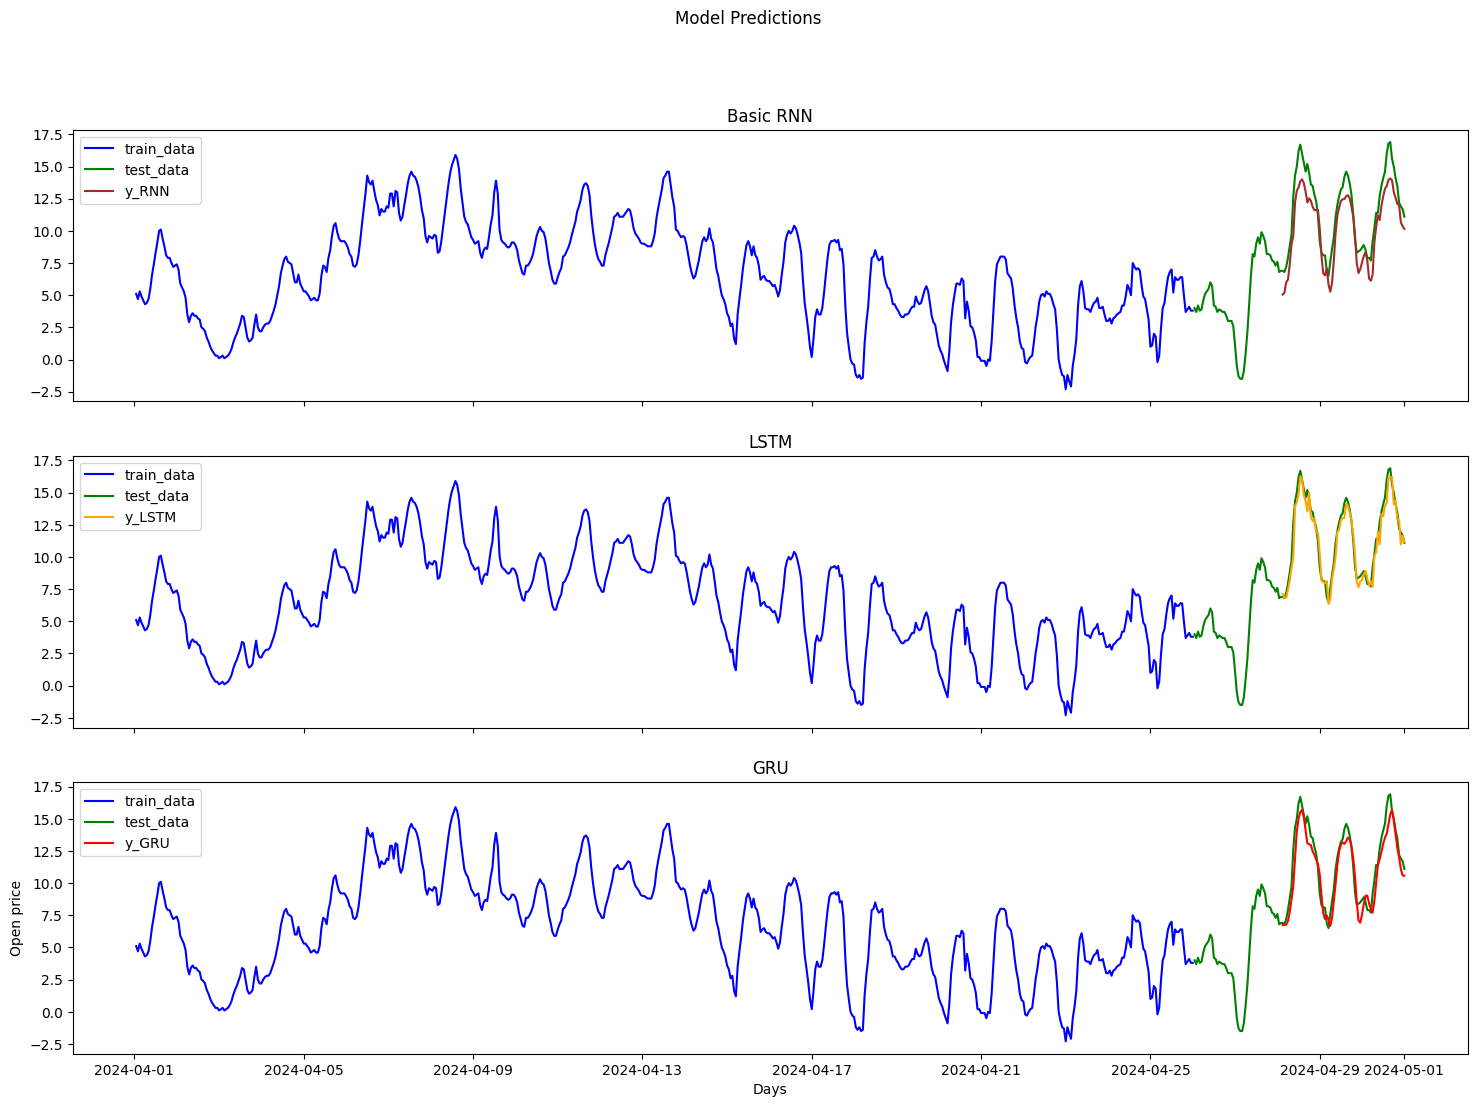

In [ ]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train.index[150:], train.Middeltemperatur[150:], label = "train_data", color = "b")
axs[0].plot(test.index, test.Middeltemperatur, label = "test_data", color = "g")
axs[0].plot(test.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train.index[150:], train.Middeltemperatur[150:], label = "train_data", color = "b")
axs[1].plot(test.index, test.Middeltemperatur, label = "test_data", color = "g")
axs[1].plot(test.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train.index[150:], train.Middeltemperatur[150:], label = "train_data", color = "b")
axs[2].plot(test.index, test.Middeltemperatur, label = "test_data", color = "g")
axs[2].plot(test.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Open price")

plt.show()
